## Uncertainty Forecasting with UMAL

This notebook is a basic example of how to implement a UMAL to forecast uncertainty. The theory is explained here and the purpose of the notebook is to explain implementation and usage details.

The notebook is divided in the following sections:

- [Time Series synthetic dataset generation](#synth_data)
- [UMAL Implementation](#umal_implementation)
- [Results](#results)
- [Conclusions](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras.layers import Lambda

tf.get_logger().setLevel('INFO')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

mpl.rcParams['figure.figsize'] = 20, 10

from poc_forecasting_uncertainty.utils import time_series_utils

Using TensorFlow backend.


### Time Series Synthetic dataset generation

#### Time series synth dataset configuration parameters

Here, we will create a synthetic seasonal time series dataset of 20 days starting at t0='2016-01-01 00:00:00' and hourly resolution. Cycles have a period pattern of 14 hours. 
- *Train*: 15 days (converted to hours)
- *Test*: 5 days (converted to hours)

Finally, we will add some white noise constant in time 

In [2]:
# ------Time series
t0 = '2016-01-01 00:00:00'
freq = 'H'
num_ts = 1

# default - changed in each experiemnt to test different behaviors
noise_level = 0.05
period = 14

# train, test
total_days = 20
tseries_length = total_days * 24 # hourly freq
train_days = 15 * 24

# ------LSTM
features = 1 # We are working with univariate series so the number of features is 1
timesteps=2 # we will work with a batch of 2 time steps

# ----- Deep Quantile Regression
QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]

In [3]:
time_series_df = time_series_utils.generate_synth_tseries(t0, tseries_length, num_ts, period, freq, noise_level)

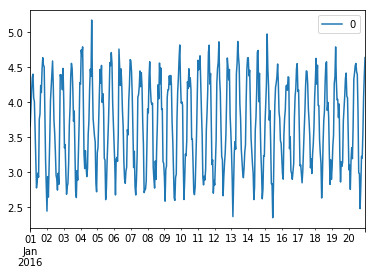

In [4]:
time_series_df.T.plot()

We split the time series dataset in **train and test**

In [5]:
train_ts = time_series_df.iloc[:, 0:train_days]
test_ts = time_series_df.iloc[:,train_days-1:-1]

In [6]:
ts_X_test, ts_Y_test = time_series_utils.split_sequence(test_ts.values[0], timesteps)
ts_X_train, ts_Y_train = time_series_utils.split_sequence(train_ts.values[0], timesteps)

# reshape X as input for the lstm [samples, timesteps, features]
X_train = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], features)) 
X_test = ts_X_test.reshape((ts_X_test.shape[0], ts_X_test.shape[1], features)) 

In [7]:
y_test = ts_Y_test.reshape((ts_Y_test.shape[0], 1))
y_train = ts_Y_train.reshape((ts_Y_train.shape[0], 1))

### UMAL Implementation

The implementation of UMAL is agnostic of the function used to estimate the predictions. In this case, we will use an LSTM for this purpose. In order to implement an UMAL so we can estimate the uncertainty distribution of the predictions we need to change the **loss function** and the **input vector** to build a composed vector of the prediction and the ALD for each prediction

#### Loss function

The UMAL loss function is adapted to **estimate the parameters of ALD contained in tensor parameters (mu, b, tau)**. We will use Maximum Likelihood Estimation to get an estimation of the parameters of the ALD distribution and the Pinball function as the loss.

In [ ]:
def independent_ALD_loss(y_true, parameters):
    """
      y_true: [bs, 1]
    """
    mu = parameters[:,:,:1] #[bs, N_taus, 1]
    b = parameters[:,:,1:2] #[bs, N_taus, 1]
    tau = parameters[:,:,-1:] #[bs, N_taus, 1]
    y_1 = y_true[:,tf.newaxis,:1] #[bs, 1, 1]
    y = tf.repeat(y_1,tf.shape(mu)[1],axis=1, name='repeat_-1') #[bs, N_taus, 1]
    factor = tf.math.log(tau) + tf.math.log(1-tau) - tf.math.log(b)

    return - tf.reduce_mean(tf.reduce_sum(factor - tf.maximum(tau*(y-mu),(tau-1.)*(y-mu))/b , 
                                         axis=1) - tf.math.log(tf.cast(tf.shape(mu)[1], tf.float32)))

#### UMAL Model

The UMAL model has 2 modes. These modes are defined by the input variable 'is_train'. It receives as input (dataset)

**Train**: We use MC sampling to **estimate the ALDs parameters of the UMAL the posterior predictive distribution** using N ALDs. The number of ALDs is defined by N_taus.
   
  - 1) **Initialization of ALDs** - We create N taus sampled from an uniform distribution. This distribution represents a non-informative prior since it gives equal values to all taus. We obtain TAU tensor.
  - 2) **Input tensor transformation** - We reshape both tensors (INPUT and TAU) to create a composed tensor as the new input for the model
  - 3) **Estimation of parameters of ALDs** - In training we will fit the parameters of the ALD with two more layers. The loss function is adapted accordingly to minimize the negative log-likelihood function with respect to the weights

**Test**: Obtain of the next point-of-estimation along with the UMAL distribution using the test observations. We receive as input the quantiles or tau list that we are interested in. These quantiles will serve as an approximation for the posterior distribution.

In [13]:
class Implicit_ALD(tf.keras.Model):
    def __init__(self):
        super(Implicit_ALD, self).__init__()
        self.h_1 = tf.keras.layers.LSTM(50, activation='relu', name='LSTM_01')
        self.h_2_mu = tf.keras.layers.Dense(1)
        self.h_2_b = tf.keras.layers.Dense(1, activation = lambda x: tf.keras.activations.elu(x+5.)+1.+1e-5)


    def call(self, inputs, N_taus = 100, is_train = True, tau = [[0.5], [0.9], [0.7]]):
        """
        inputs: [bs, ts, f]
        """
        # 2 EXECUTION MODES - Train and test
        if is_train: # MC sampling to estimate the ALDs parameters of the UMAL posterior predictive distribution
            # Initialization of ALDs - we create as many taus as obs in the batch (bs) 
            tau = tf.random.uniform((tf.shape(inputs)[0], N_taus, 1, 1), minval=1e-2, maxval=1.-1e-2) # [bs, N_taus, 1, 1]
        else:
            tau = tf.repeat(tf.reshape(tau,(1,-1,1,1), name='reshape_0'), repeats=tf.shape(inputs)[0], axis=0, name='repeat_0') # [bs, N_taus, 1, 1]
            N_taus = np.shape(tau)[1]
    
        #---------------- Input tensor transformation
        i_1 = tf.keras.backend.expand_dims(inputs,axis=1) #[bs, 1, ts, fs]

        # RESHAPE INPUT and TAU - Adapt the input to be able to associate each input point with a tau
        i_b = tf.repeat(i_1, N_taus, axis=1, name='repeat_1') #[bs, N_taus, ts, fs]
        tau_b = tf.repeat(tau, inputs.shape[1], axis=2, name='repeat_2') #[bs, N_taus, ts, fs]
    
        # CONCAT INPUT and TAU - Build the final input of the model
        input_tau = tf.keras.layers.concatenate([i_b, tau_b], axis=-1) # [bs, N_taus, ts, fs+1]
        input_tau = tf.reshape(input_tau, [-1, tf.shape(inputs)[1], inputs.shape[-1]+1], name='repeat_3') #[bs * N_taus, ts, fs+1]

        #---------------- Model 
        # MODEL - Apply any deep learning function - we use a LSTM as defined in the constructor 
        hidden_1 = self.h_1(input_tau)
        hidden_2_mu = self.h_2_mu(hidden_1) #[bs, N_taus, 1]
        hidden_2_b = self.h_2_b(hidden_1) #[bs, N_taus, 1]

        output_tau = tf.keras.layers.concatenate([tf.reshape(hidden_2_mu, tf.shape(tau[...,0]), name='reshape_4_mu'), 
                                              tf.reshape(hidden_2_b, tf.shape(tau[...,0]), name='reshape_4_b'), 
                                              tau[...,0]], 
                                             axis=-1)

        return output_tau

In [14]:
model = Implicit_ALD()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss = independent_ALD_loss)
independent_ALD_loss(y_train[:100].astype('float32'), model(X_train[:100])).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([])

Train on 106 samples, validate on 12 samples
Epoch 1/10000
106/106 [==============================] - 3s 28ms/sample - loss: 409.2161 - val_loss: 404.8680
Epoch 2/10000
106/106 [==============================] - 0s 593us/sample - loss: 406.9765 - val_loss: 402.2118
Epoch 3/10000
106/106 [==============================] - 0s 452us/sample - loss: 404.6366 - val_loss: 405.2273
Epoch 4/10000
106/106 [==============================] - 0s 452us/sample - loss: 405.1385 - val_loss: 405.2452
Epoch 5/10000
106/106 [==============================] - 0s 480us/sample - loss: 404.2952 - val_loss: 400.4307
Epoch 6/10000
106/106 [==============================] - 0s 470us/sample - loss: 403.4326 - val_loss: 398.8333
Epoch 7/10000
106/106 [==============================] - 0s 442us/sample - loss: 401.5947 - val_loss: 399.4229
Epoch 8/10000
106/106 [==============================] - 0s 452us/sample - loss: 401.2726 - val_loss: 397.3039
Epoch 9/10000
106/106 [==============================] - 0s 480us/sa

Epoch 74/10000
106/106 [==============================] - 0s 386us/sample - loss: 141.6368 - val_loss: 179.9647
Epoch 75/10000
106/106 [==============================] - 0s 442us/sample - loss: 140.0800 - val_loss: 185.3732
Epoch 76/10000
106/106 [==============================] - 0s 405us/sample - loss: 140.3266 - val_loss: 178.4596
Epoch 77/10000
106/106 [==============================] - 0s 339us/sample - loss: 138.5742 - val_loss: 185.0961
Epoch 78/10000
106/106 [==============================] - 0s 376us/sample - loss: 139.1854 - val_loss: 186.1552
Epoch 79/10000
106/106 [==============================] - 0s 376us/sample - loss: 137.6804 - val_loss: 179.4982
Epoch 80/10000
106/106 [==============================] - 0s 395us/sample - loss: 137.6513 - val_loss: 181.3856
Epoch 81/10000
106/106 [==============================] - 0s 386us/sample - loss: 136.7257 - val_loss: 179.7321
Epoch 82/10000
106/106 [==============================] - 0s 376us/sample - loss: 137.0461 - val_loss: 1

Epoch 147/10000
106/106 [==============================] - 0s 414us/sample - loss: 87.1548 - val_loss: 123.5527
Epoch 148/10000
106/106 [==============================] - 0s 480us/sample - loss: 85.6894 - val_loss: 115.9454
Epoch 149/10000
106/106 [==============================] - 0s 386us/sample - loss: 86.0001 - val_loss: 116.2402
Epoch 150/10000
106/106 [==============================] - 0s 489us/sample - loss: 86.0345 - val_loss: 118.1851
Epoch 151/10000
106/106 [==============================] - 0s 489us/sample - loss: 84.3095 - val_loss: 121.2554
Epoch 152/10000
106/106 [==============================] - 0s 386us/sample - loss: 83.4049 - val_loss: 119.9034
Epoch 153/10000
106/106 [==============================] - 0s 470us/sample - loss: 82.4659 - val_loss: 113.2109
Epoch 154/10000
106/106 [==============================] - 0s 423us/sample - loss: 83.1854 - val_loss: 112.4541
Epoch 155/10000
106/106 [==============================] - 0s 391us/sample - loss: 82.5828 - val_loss: 1

106/106 [==============================] - 0s 348us/sample - loss: 64.8632 - val_loss: 94.8641
Epoch 221/10000
106/106 [==============================] - 0s 358us/sample - loss: 64.5099 - val_loss: 90.7551
Epoch 222/10000
106/106 [==============================] - 0s 376us/sample - loss: 65.4577 - val_loss: 93.3055
Epoch 223/10000
106/106 [==============================] - 0s 395us/sample - loss: 64.9339 - val_loss: 98.5436
Epoch 224/10000
106/106 [==============================] - 0s 405us/sample - loss: 64.2095 - val_loss: 90.8532
Epoch 225/10000
106/106 [==============================] - 0s 442us/sample - loss: 63.8366 - val_loss: 91.2886
Epoch 226/10000
106/106 [==============================] - 0s 470us/sample - loss: 64.0563 - val_loss: 91.3987
Epoch 227/10000
106/106 [==============================] - 0s 424us/sample - loss: 62.7315 - val_loss: 91.8821
Epoch 228/10000
106/106 [==============================] - 0s 442us/sample - loss: 63.3844 - val_loss: 93.1001
Epoch 229/10000
1

106/106 [==============================] - 0s 433us/sample - loss: 53.8376 - val_loss: 77.4605
Epoch 294/10000
106/106 [==============================] - 0s 386us/sample - loss: 54.1443 - val_loss: 73.2464
Epoch 295/10000
106/106 [==============================] - 0s 405us/sample - loss: 54.3564 - val_loss: 75.7744
Epoch 296/10000
106/106 [==============================] - 0s 386us/sample - loss: 53.9940 - val_loss: 77.2089
Epoch 297/10000
106/106 [==============================] - 0s 480us/sample - loss: 52.6313 - val_loss: 76.4467
Epoch 298/10000
106/106 [==============================] - 0s 414us/sample - loss: 52.8083 - val_loss: 74.3333
Epoch 299/10000
106/106 [==============================] - 0s 423us/sample - loss: 53.9545 - val_loss: 74.6683
Epoch 300/10000
106/106 [==============================] - 0s 433us/sample - loss: 54.0090 - val_loss: 74.4648
Epoch 301/10000
106/106 [==============================] - 0s 480us/sample - loss: 52.4471 - val_loss: 74.0685
Epoch 302/10000
1

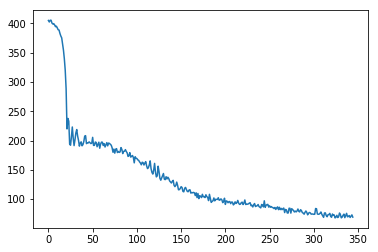

In [16]:
es = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X_test, y_test, validation_split=0.1,verbose=1, epochs=10000, callbacks=[es])

from matplotlib import pyplot as plt
plt.plot(history.history['val_loss'])

In [43]:
tau_list = [[0.1],[0.3],[0.5],[0.7],[0.9]] 

In [44]:
pred = model(X_test, is_train=False, tau=tau_list, N_taus=3)

In [45]:
pred.shape

TensorShape([118, 5, 3])

In [50]:
def plot_ts_forecast(ts_Y_train, ts_Y_test, pred):
    plt.figure(figsize=(20,10))
    forecast_h = pred.shape[0]
    train_window = len(ts_Y_train)
    x_length = forecast_h+train_window    
    x_range = np.arange(x_length)

    plt.plot(x_range[:train_window], X_train[:, 1,0], '-o', label="train")
    plt.plot(x_range[train_window:], X_test[:,1,0], '-o', label="test")
    plt.errorbar(x_range[train_window:], pred[:,0,0], yerr=pred[:,0,1], label='$q_{0.1}$')
    plt.errorbar(x_range[train_window:], pred[:,1,0], yerr=pred[:,1,1], label='$q_{0.3}$')
    plt.errorbar(x_range[train_window:], pred[:,2,0], yerr=pred[:,2,1], label='$q_{0.5}$')
    plt.errorbar(x_range[train_window:], pred[:,3,0], yerr=pred[:,3,1], label='$q_{0.7}$')
    plt.errorbar(x_range[train_window:], pred[:,4,0], yerr=pred[:,4,1], label='$q_{0.9}$')
    plt.tight_layout()
    plt.subplots_adjust(left=0.07)
    plt.xlabel('time step', size=15)
    plt.legend(fontsize=15)

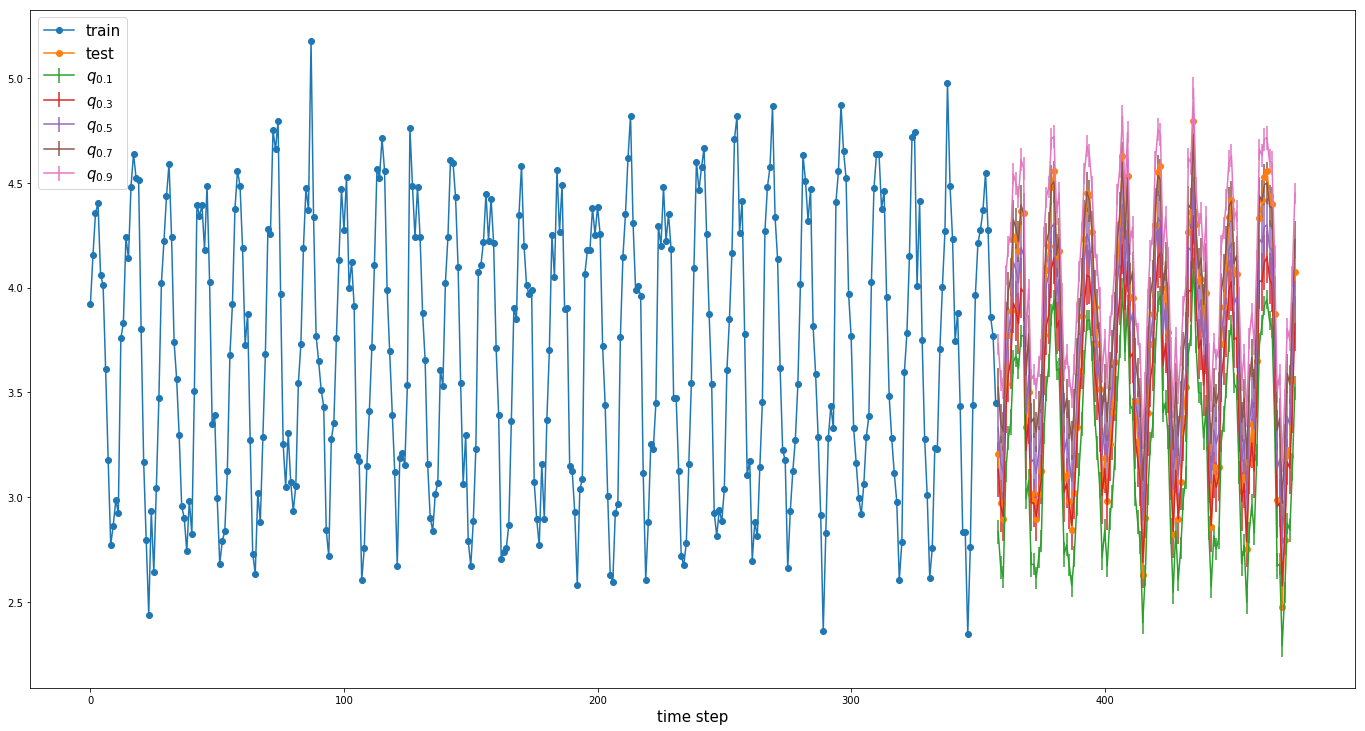

In [51]:
plot_ts_forecast(ts_Y_train, ts_Y_test, pred)

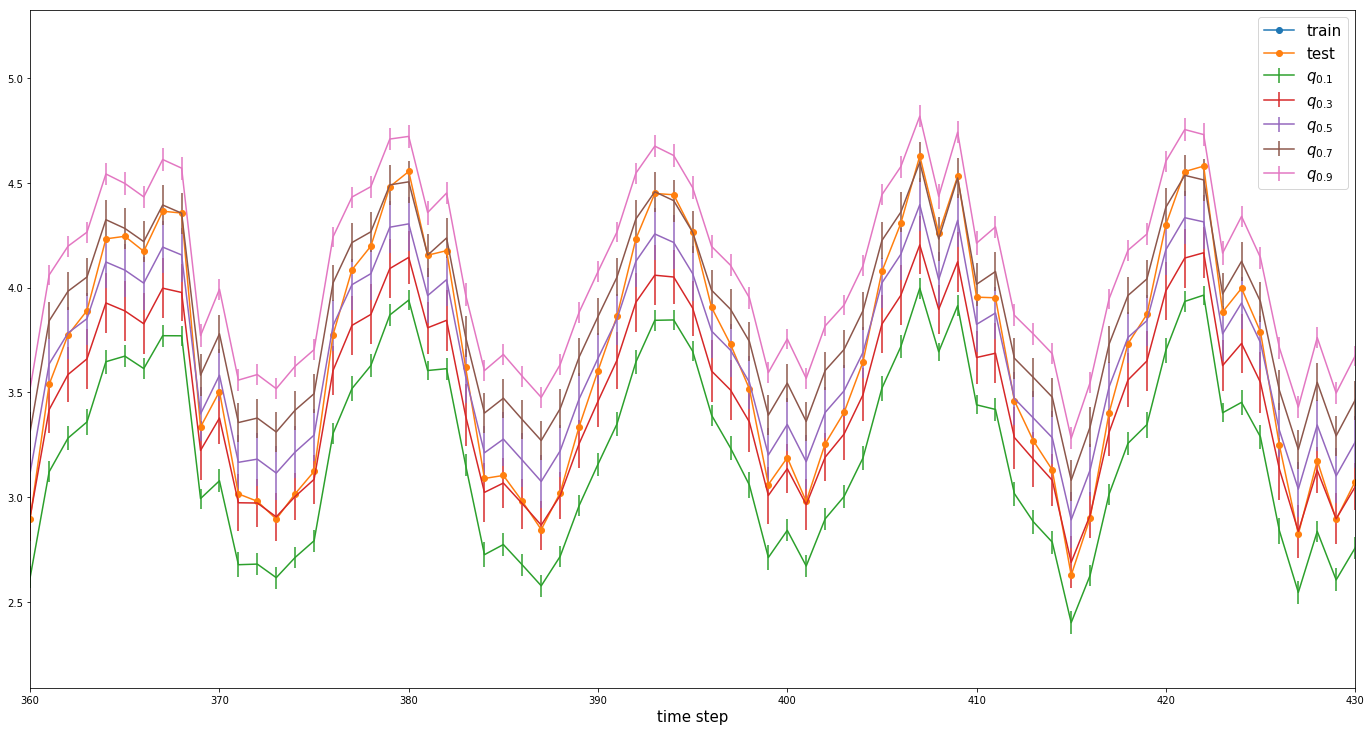

In [56]:
plot_ts_forecast(ts_Y_train, ts_Y_test, pred)
plt.xlim(360,430)
plt.show()

## Conclusions

TODO